Aplicação do modelo KAN.
As funções da multiplicação são adicionadas ao modelo

In [1]:
import torch
from kan import KAN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv("/home/nail/Documents/Natalia/IoT/Datas/CIC_IOT_Dataset2023/IoT_Intrusion/IoT_Intrusion.csv")

In [3]:
df = df.dropna()

In [4]:
X = df[df.columns[0:-1]].fillna(0).reset_index(drop=True)
y = df['label']== 'BenignTraffic'

In [5]:
# Splitting data to train val test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)

# Converting data to Torch tensor
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.long)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.long)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Проверка размеров полученных выборок
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 734002
Validation size: 157286
Test size: 157287


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Обучаем случайный лес для оценки важности признаков
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Получаем важность признаков
importance = model.feature_importances_

# Сортируем по важности
indices = np.argsort(importance)[::-1]

In [7]:
# Выбираем топ-N признаков
N = 10
top_n_indices = indices[:N]

# Отбираем только топ-N признаков из обучающего набора
X_train_selected = X_train.iloc[:, top_n_indices]  # Для DataFrame используем iloc
X_val_selected = X_val.iloc[:, top_n_indices]      # Для DataFrame используем iloc

In [8]:
# Обучение модели на отобранных признаках
model = RandomForestClassifier()
model.fit(X_train_selected, y_train)

# Прогнозирование на валидационных данных
y_pred = model.predict(X_val_selected)

# Оценка точности
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy with top {N} features: {accuracy:.4f}")

Accuracy with top 10 features: 0.9972


In [9]:
import torch
import torch.optim as optim
import time
import numpy as np

# Проверка доступности устройства (GPU или CPU)
device = torch.device("cpu")  # Или "cuda" для GPU

# Инициализация модели
model = KAN(width=[10, [5, 3], 2], grid=5, k=2) # Убедитесь, что модель корректно определена

# Перемещаем модель на устройство
model.to(device)

# Подготовка данных
X_train_selected = X_train.iloc[:, top_n_indices].to_numpy()
X_val_selected = X_val.iloc[:, top_n_indices].to_numpy()
X_test_selected = X_test.iloc[:, top_n_indices].to_numpy()

# Преобразуем отобранные данные в тензоры
train_input = torch.tensor(X_train_selected, dtype=torch.float32).to(device)
val_input = torch.tensor(X_val_selected, dtype=torch.float32).to(device)
test_input = torch.tensor(X_test_selected, dtype=torch.float32).to(device)

train_label = train_label.to(device)
val_label = val_label.to(device)
test_label = test_label.to(device)

# Проверка размеров данных
print(f"Train input shape: {train_input.shape}")
print(f"Val input shape: {val_input.shape}")
print(f"Test input shape: {test_input.shape}")

checkpoint directory created: ./model
saving model version 0.0
Train input shape: torch.Size([734002, 10])
Val input shape: torch.Size([157286, 10])
Test input shape: torch.Size([157287, 10])


In [10]:
# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция потерь
criterion = torch.nn.CrossEntropyLoss()

# Функция для вычисления точности
def train_acc():
    model.eval()  # Убедимся, что модель в режиме оценки (без обновления градиентов)
    with torch.no_grad():
        preds = torch.argmax(model(train_input), dim=1)
        accuracy = torch.mean((preds == train_label).float())
    print(f"Train Accuracy: {accuracy.item():.4f}")
    return accuracy

def test_acc():
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(test_input), dim=1)
        print(classification_report(test_label,preds))
        accuracy = torch.mean((preds == test_label).float())
    print(f"Test Accuracy: {accuracy.item():.4f}")
    return accuracy

In [11]:

# Замер времени обучения
start_train_time = time.perf_counter()

# Обучение модели
for step in range(100):  # Количество шагов (итераций)
    try:
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прогон через модель
        outputs = model(train_input)
        
        # Вычисляем функцию потерь
        loss = criterion(outputs, train_label)
        
        # Вычисляем градиенты
        loss.backward()
        
        # Шаг оптимизатора
        optimizer.step()
        
        # Печать каждые 10 шагов
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")
    except Exception as e:
        print(f"Error at step {step}: {str(e)}")
        break

end_train_time = time.perf_counter()

# Замер времени выполнения предсказаний
start_predict_time = time.perf_counter()

model.eval()
with torch.no_grad():
    val_pred = model(val_input)

end_predict_time = time.perf_counter()

# После тренировки модели вычисляем точность
train_accuracy = train_acc()
val_accuracy = test_acc()

# Вывод результатов
print(f"Train Accuracy: {train_accuracy.item():.4f}")
print(f"Validation Accuracy: {val_accuracy.item():.4f}")

# Вывод времени обучения и времени предсказания
train_time = end_train_time - start_train_time
predict_time = end_predict_time - start_predict_time
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")

# Освобождаем память
torch.cuda.empty_cache()

Step 0, Loss: 1091982458880.0000
Step 10, Loss: 639160483840.0000
Step 20, Loss: 257424113664.0000
Step 30, Loss: 13538187264.0000
Step 40, Loss: 29938737152.0000
Step 50, Loss: 24575164416.0000
Step 60, Loss: 39912480768.0000
Step 70, Loss: 69249024000.0000
Step 80, Loss: 37725143040.0000
Step 90, Loss: 7898694656.0000
Train Accuracy: 0.9807
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    153679
           1       0.61      0.48      0.54      3608

    accuracy                           0.98    157287
   macro avg       0.80      0.74      0.76    157287
weighted avg       0.98      0.98      0.98    157287

Test Accuracy: 0.9810
Train Accuracy: 0.9807
Validation Accuracy: 0.9810
Training Time: 864.4360 seconds
Prediction Time: 0.7326 seconds


In [13]:
test_acc()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    153679
           1       0.61      0.48      0.54      3608

    accuracy                           0.98    157287
   macro avg       0.80      0.74      0.76    157287
weighted avg       0.98      0.98      0.98    157287

Test Accuracy: 0.9810


tensor(0.9810)

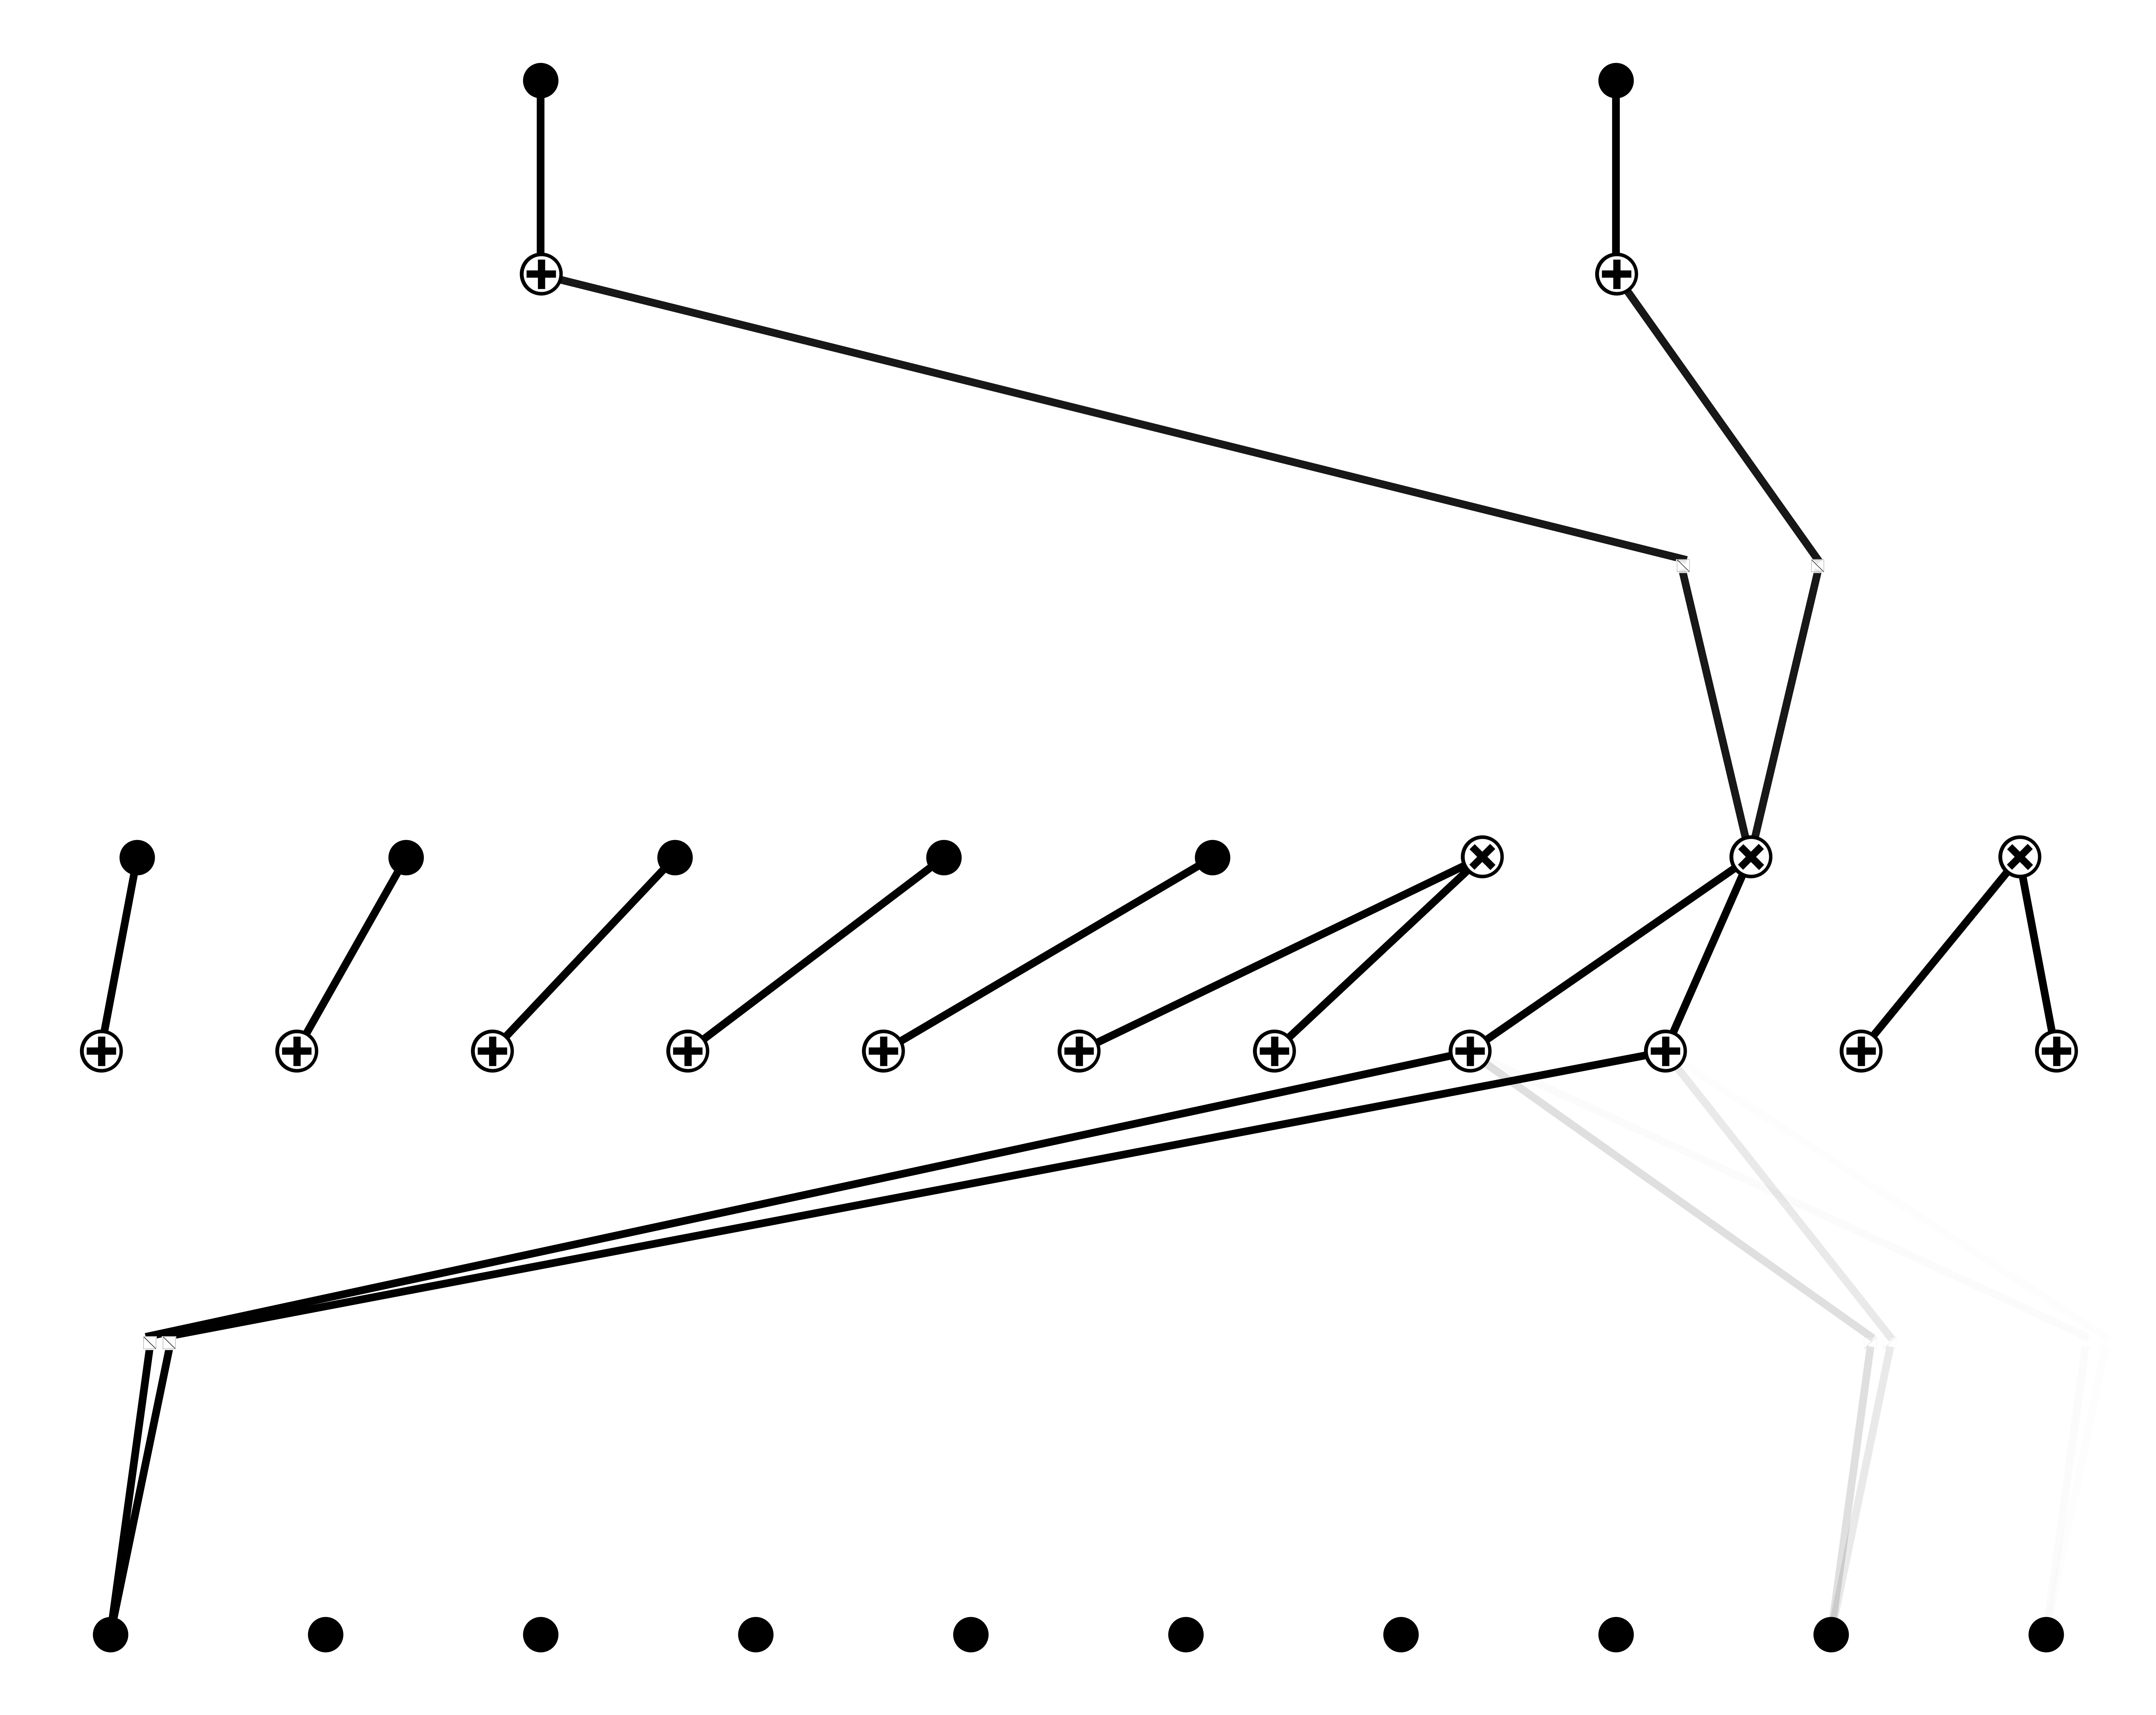

In [12]:
# Plotting KAN network
model.plot(scale=10)

plt.savefig("fig20.png")  # dpi можно настроить для повышения качества



In [13]:
model = model.prune()

saving model version 0.1


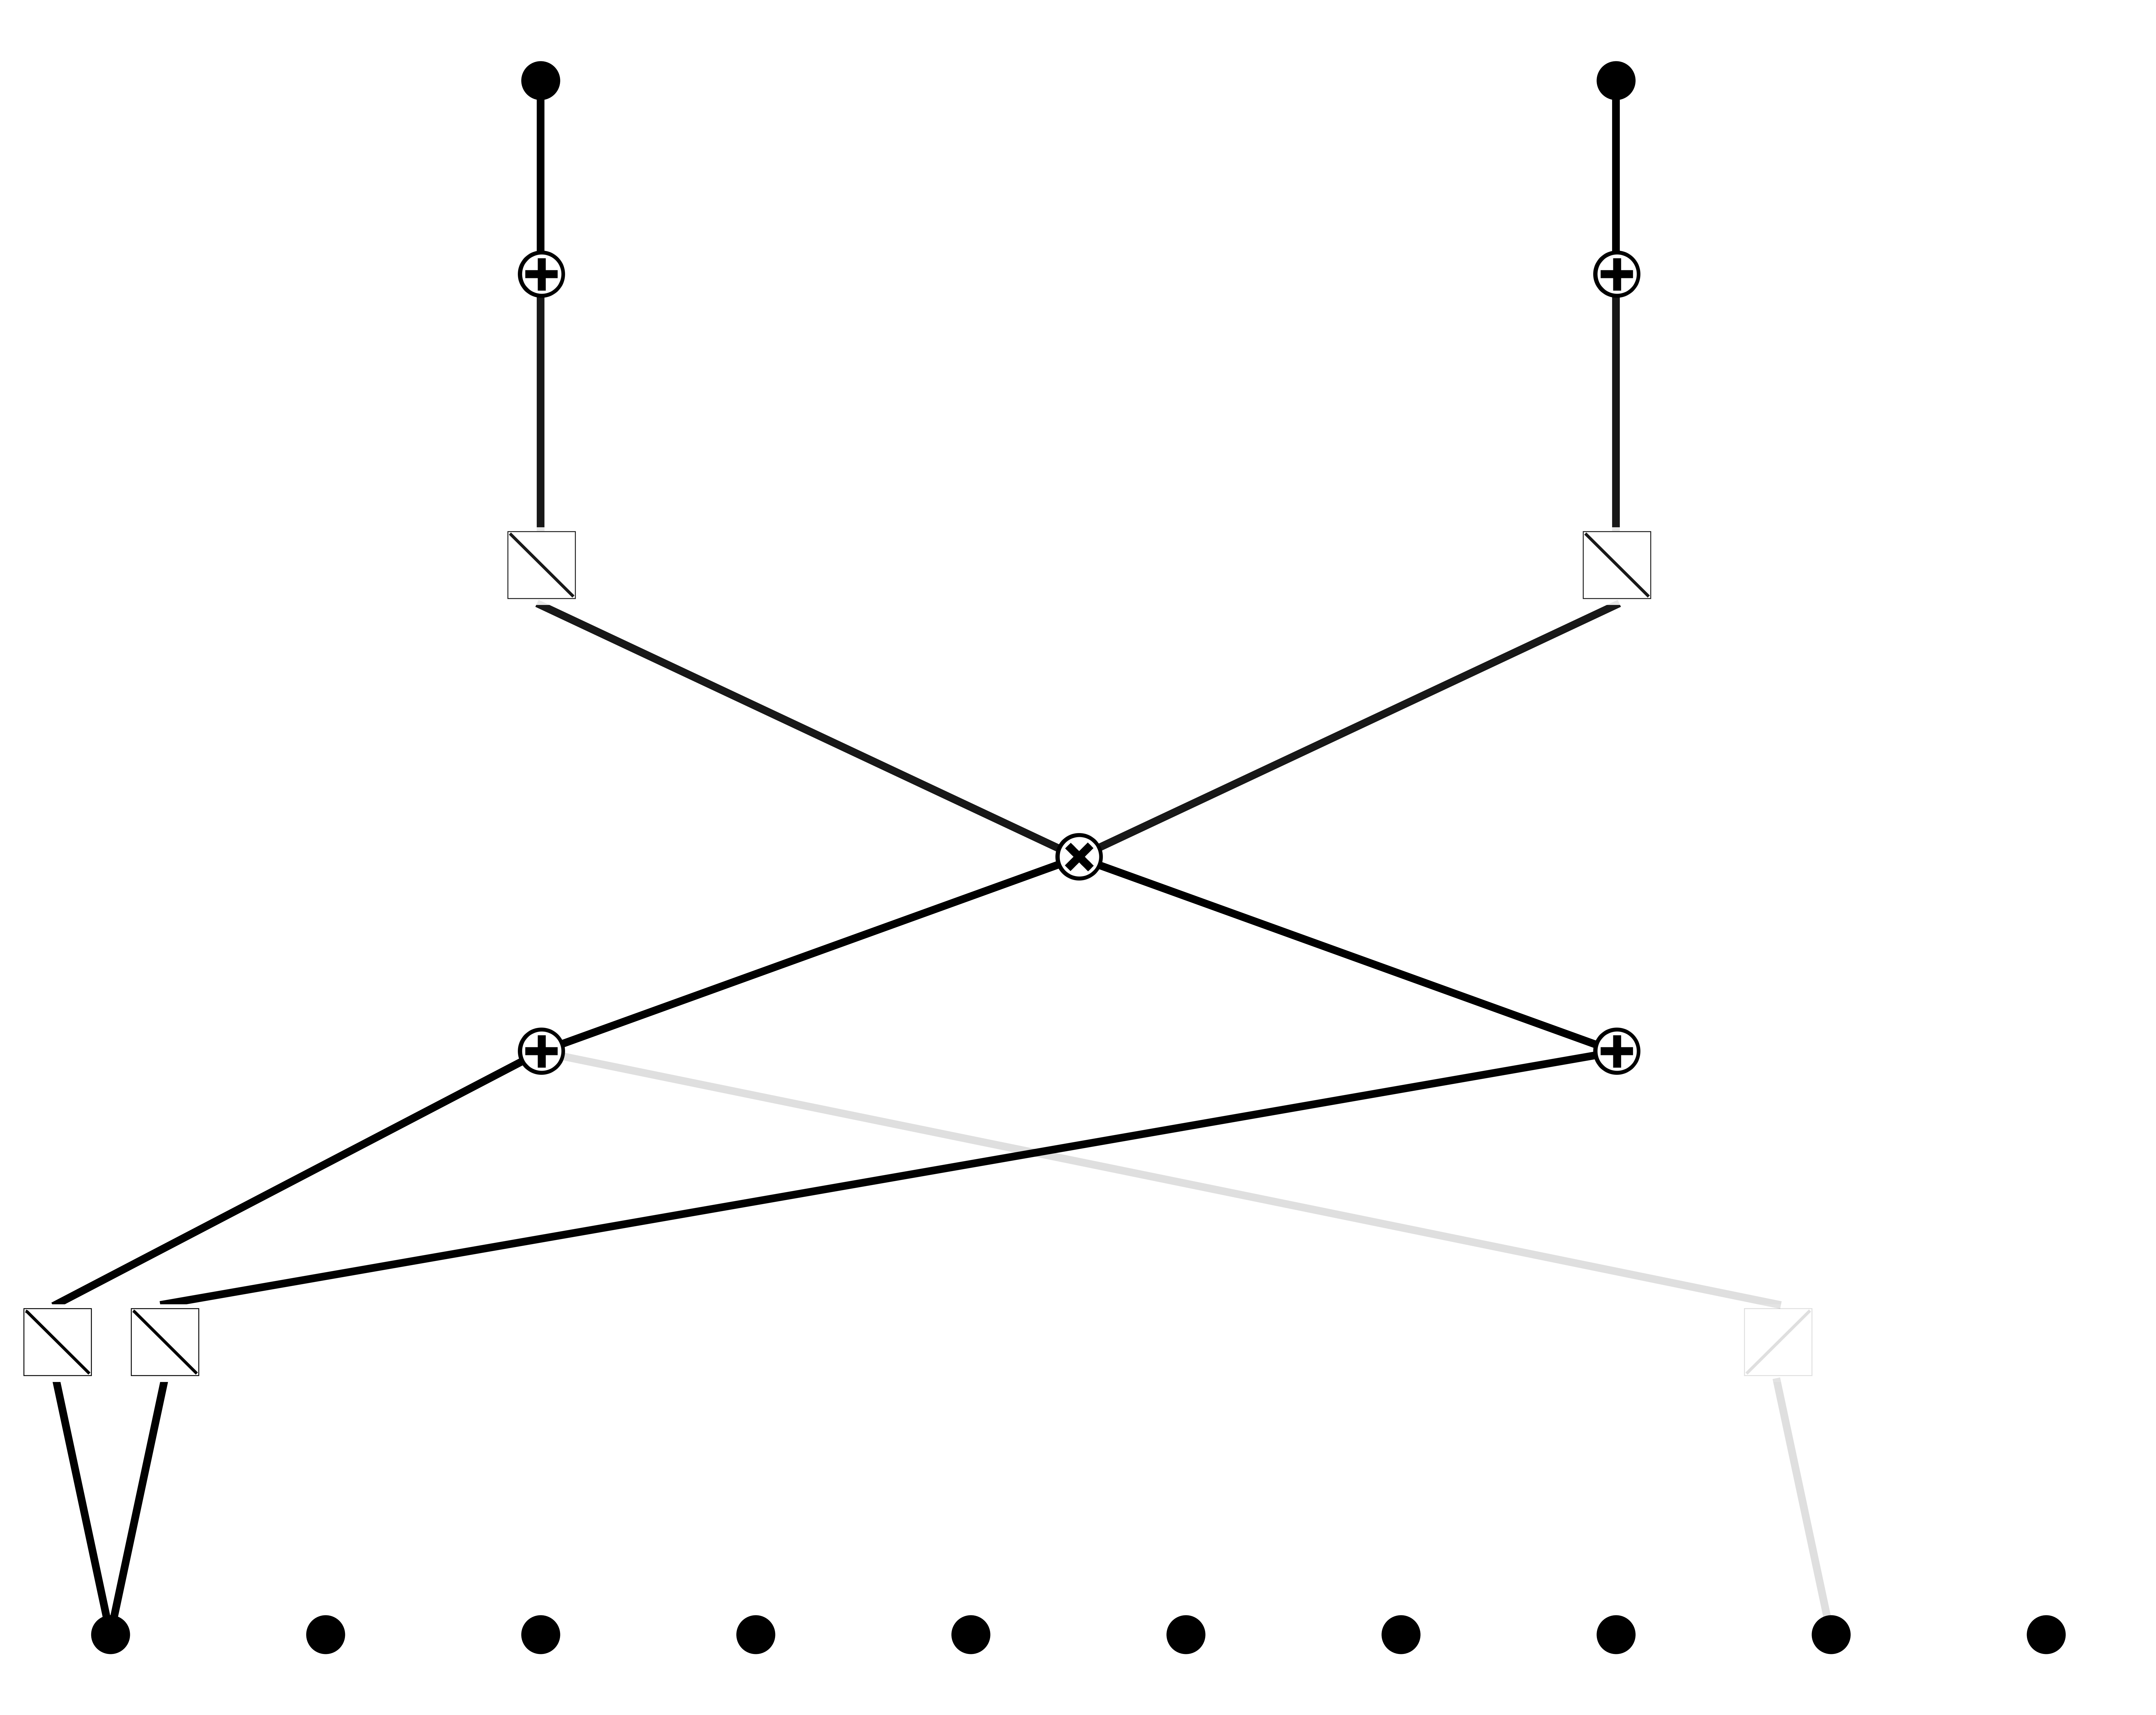

In [14]:
# Plotting KAN network
model.plot(scale=10)
plt.savefig("fig21.png")

In [15]:
model = model.prune()

saving model version 0.1


In [16]:
model.plot(scale=10)
plt.savefig("fig12.png")

In [17]:
model = model.prune()

saving model version 0.3


In [18]:
model.plot(scale=10)
plt.savefig("fig13.png")

In [ ]:
model.auto_symbolic()

In [1]:
print(model.symbolic_formula())

NameError: name 'model' is not defined